In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

### Define the bandit environment with Bernoulli rewards

In [2]:
class BernoulliBanditEnv(object):
    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)

        # probability of reward for each arm
        if p==None:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            warning()
        self.best_action = np.argmax(self.p)

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


### Define an agent class that contains several learning and decision rules

In [3]:
class Agent(object):
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule
        self.iteration = 0
        # organize parameters of learning rules in what follows
        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
            
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
                    
        if learning_rule == "RW":
            self.learning_rate = param["learning_rate"]
            
    def environment(self, env, init_q):
        self.env = env
        self.k = env.num_arms
        self.actions = np.arange(self.k)
        self.act_count = np.zeros(self.k)
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if not (len(init_q) == self.k):
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))
        else:
            self.q_estimate = init_q

    def learn(self, a, r):
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])

        if self.learning_rule == "RW":
            self.act_count[a] += 1
            self.q_estimate[a] += self.learning_rate * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            # Bayesian update of Beta distribution
            self.act_count[a] += 1
            self.alpha[a] += r
            self.beta[a] += 1 - r    
            
    def act(self):
        self.iteration += 1
        if self.decision_rule == "greedy":
            q_best = np.max(self.q_estimate)
            selected_action = np.random.choice([action for action, q in enumerate(self.q_estimate) if q == q_best])

        if self.decision_rule == "epsilon-greedy":
            if np.random.rand() < self.epsilon:   # with probability epsilon select a random arm
                selected_action = np.random.choice(self.actions)
            else:                                 # else apply the greedy choice
                selected_action = np.argmax(self.q_estimate)

        if self.decision_rule == "UCB":
            UCB_objective = self.q_estimate + self.UCB_param * \
                np.sqrt(np.log(self.iteration) / (self.act_count + np.finfo(float).eps))  # add small number (machine precision) to avoid divergence at zero
            q_best = np.max(UCB_objective)    # there are possibly multiple arms with the same Q value, pick at random among those:
            selected_action = np.random.choice([action for action, q in enumerate(UCB_objective) if q == q_best])

        if self.decision_rule == "Thompson":
            # sample q-values from the Beta distribution
            selected_action = np.argmax(np.random.beta(self.alpha, self.beta))
        
        self.act_count[selected_action] += 1

        return selected_action

In [4]:
def simulateBandits(agents, narms, initp=None, initq=None, runs=2000, N=100):
    rewards = np.zeros((len(agents), runs, N))
    bestarm = np.zeros((len(agents), runs, N))
    for i, agent in enumerate(agents):
        for j in np.arange(runs):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0    # did the agent choose the best action?
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

## Simulate!

In [5]:
# run simulations
arms = 2
epsilons = [0.1, 0.9]
agents = []
# initialize agents
agents.append(Agent("averaging", "UCB", {"UCB_param":0.5}))
agents.append(Agent("BayesianBetaPrior", "Thompson",{"alpha":0.5, "beta":0.3}))
for eps in epsilons:
    agents.append(Agent("averaging", "epsilon-greedy", {"epsilon":eps}))
agents.append(Agent("averaging", "greedy"))

start = time()
rewards, actions = simulateBandits(agents, arms)
print("Elapsed simulation time: {} min".format((time() - start)/60.))

Elapsed simulation time: 31.41312050819397 min


## Plotting the results

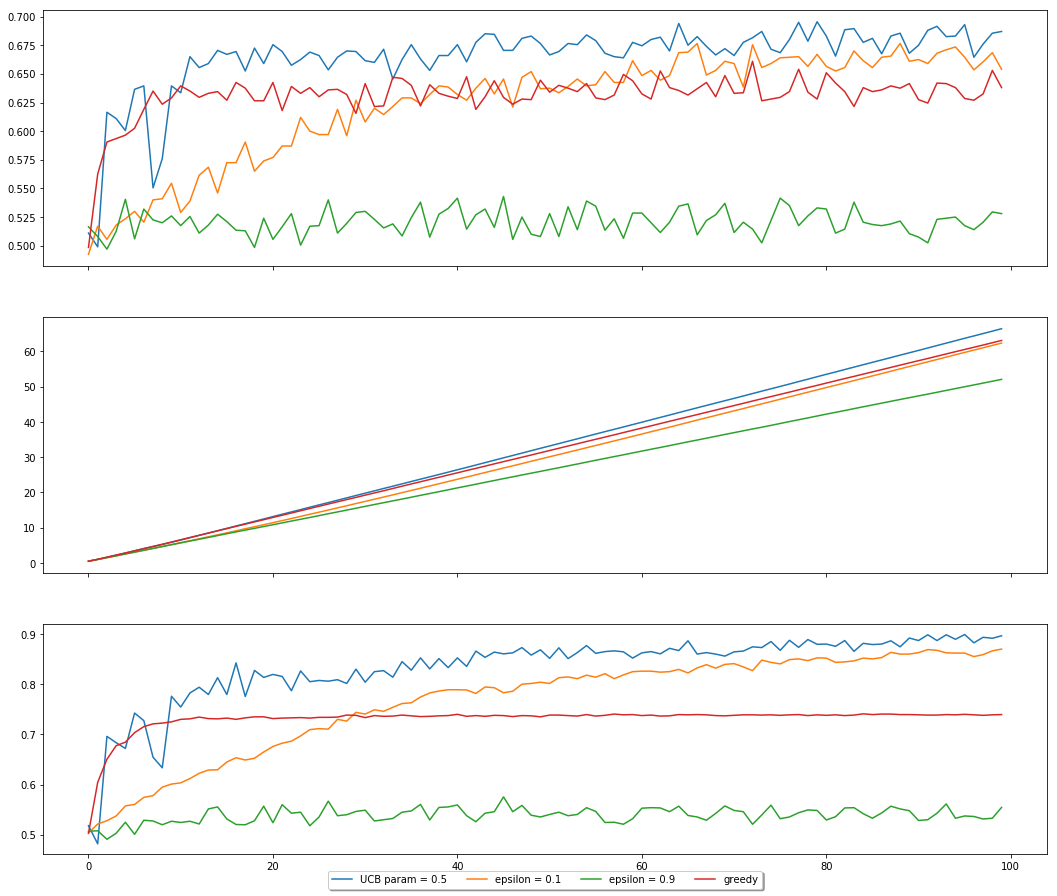

In [6]:
# plot achieved rewards and actions
fig, ax = plt.subplots(3,1, sharex='all', figsize=(16, 14))

ax[0].set_ylabel("average reward")
for i, a in enumerate(agents):
    if a.decision_rule == "epsilon-greedy":
        ax[0].plot(rewards[i, :], label='epsilon = {}'.format(a.epsilon))
    elif a.decision_rule == "UCB":
        ax[0].plot(rewards[i, :], label='UCB param = {}'.format(a.UCB_param))
    else:
        ax[0].plot(rewards[i, :], label=a.decision_rule)

ax[1].set_ylabel("cumulative reward")
for i, a in enumerate(agents):
    if a.decision_rule == "epsilon-greedy":
        ax[1].plot(np.cumsum(rewards[i, :]), label='epsilon = {}'.format(a.epsilon))
    elif a.decision_rule == "UCB":
        ax[1].plot(np.cumsum(rewards[i, :]), label='UCB param = {}'.format(a.UCB_param))
    else:
        ax[1].plot(np.cumsum(rewards[i, :]), label=a.decision_rule)

ax[2].set_ylabel("average best arm picks")
for i, a in enumerate(agents):
    if a.decision_rule == "epsilon-greedy":
        ax[2].plot(actions[i, :], label='epsilon = {}'.format(a.epsilon))
    elif a.decision_rule == "UCB":
        ax[2].plot(actions[i, :], label='UCB param = {}'.format(a.UCB_param))
    else:
        ax[2].plot(actions[i, :], label=a.decision_rule)


# Shrink current axis's height by 10% on the bottom
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.show()